In [1]:
import pickle
import numpy as np
from sklearn.utils import shuffle

d = pickle.load(open('train_data.p', 'rb'))
train_x = np.array(d['train_x'], dtype=np.float32)
train_y = np.array(d['train_y'])

train_y[train_y == -1] = 0

train_x, train_y = shuffle(train_x, train_y)
train_x = train_x - 128
train_x = train_x / 128

print('Loaded.')

Loaded.


In [2]:
print(train_x.shape, train_y.shape)

(25000, 32, 32, 3) (25000,)


1 1 0 1
0.992188 -1.0


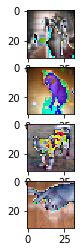

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

print(train_y[500], train_y[501], train_y[502], train_y[503])
print (np.max(train_x), np.min(train_x))

plt.subplot(411)
plt.imshow(train_x[500])
plt.subplot(412)
plt.imshow(train_x[501])
plt.subplot(413)
plt.imshow(train_x[502])
plt.subplot(414)
plt.imshow(train_x[503])



In [4]:
import tensorflow as tf
def model(x):
    w_l1 = tf.Variable(tf.random_normal([4,4,3,20]))
    b_l1 = tf.Variable(tf.random_normal([20]))
    conv1 = tf.nn.conv2d(x, w_l1, [1,1,1,1], 'VALID') + b_l1
    relu1 = tf.nn.relu(conv1)
    maxpool1 = tf.nn.max_pool(relu1, [1,2,2,1], [1,2,2,1], 'VALID')
    
    w_l2 = tf.Variable(tf.random_normal([4,4,20,40]))
    b_l2 = tf.Variable(tf.random_normal([40]))
    conv2 = tf.nn.conv2d(maxpool1, w_l2, [1,1,1,1], 'VALID') + b_l2
    relu2 = tf.nn.relu(conv2)
    maxpool2 = tf.nn.max_pool(relu2, [1,2,2,1], [1,2,2,1], 'VALID')    
    flat = tf.contrib.layers.flatten(maxpool2)

    f1_w = tf.Variable(tf.random_normal([1000, 100]))
    f1_b = tf.Variable(tf.random_normal([100]))
    full1 = tf.add(tf.matmul(flat, f1_w), f1_b)
    
    f2_w = tf.Variable(tf.random_normal([100, 2]))
    f2_b = tf.Variable(tf.random_normal([2]))
    full2 = tf.add(tf.matmul(full1, f2_w), f2_b)
    
    return full2
                       

print(model(train_x[1].reshape((1,32,32,3))))
    

Tensor("Add_1:0", shape=(1, 2), dtype=float32)


In [28]:

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))

rate = 0.001
one_hot_y = tf.one_hot(y, 2)
logits = model(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = one_hot_y)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate, name="optimizer").minimize(cost)

correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

pred = tf.argmax(tf.nn.softmax(logits),1)
print(logits.shape, pred.shape)

(?, 2) (?,)


In [33]:
nt = 2000
validation_size = 500

xt = train_x[0:nt]
yt = train_y[0:nt]

xv = train_x[-validation_size:]
yv = train_y[-validation_size:]

print (xt.shape, yt.shape, xv.shape, yv.shape)

(2000, 32, 32, 3) (2000,) (500, 32, 32, 3) (500,)


In [34]:
batch_size = 50
batch_n = int(len(xt)/batch_size)
epochs = 20
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for e in range(epochs):
        for b in range(batch_n):
            x_batch, y_batch = xt[b:(b+1) * batch_size], yt[b:(b+1) * batch_size]
            sess.run(optimizer, feed_dict={x: x_batch, y: y_batch})
            lost = sess.run(cost, feed_dict={x: x_batch, y: y_batch})
            acc_b = sess.run(accuracy, feed_dict={x: x_batch, y: y_batch})
            acc_ft = sess.run(accuracy, feed_dict={x: xt, y: yt})
            acc_val = sess.run(accuracy, feed_dict={x: xv, y:yv})
            
            print ("e: {}, b: {}/{}, lost : {}, acc: {}, {}, acc_val: {}".format(e, b, batch_n, lost, acc_b, acc_ft, acc_val))

        
    """for u in range(nt):
        pr = sess.run(pred, feed_dict={x: xt[u].reshape((1,32,32,3))})
        print(yt[u], pr)"""
  
    print("done.")

e: 0, b: 0/40, lost : 7384.84423828125, acc: 0.47999998927116394, 0.515999972820282, acc_val: 0.5400000214576721
e: 0, b: 1/40, lost : 5514.00634765625, acc: 0.49494948983192444, 0.5164999961853027, acc_val: 0.5299999713897705
e: 0, b: 2/40, lost : 4588.76416015625, acc: 0.5, 0.5095000267028809, acc_val: 0.527999997138977
e: 0, b: 3/40, lost : 4458.623046875, acc: 0.5025380849838257, 0.5059999823570251, acc_val: 0.527999997138977
e: 0, b: 4/40, lost : 4556.345703125, acc: 0.5243902206420898, 0.4984999895095825, acc_val: 0.5080000162124634
e: 0, b: 5/40, lost : 4525.56884765625, acc: 0.508474588394165, 0.4964999854564667, acc_val: 0.4860000014305115
e: 0, b: 6/40, lost : 4590.34228515625, acc: 0.520348846912384, 0.5040000081062317, acc_val: 0.48399999737739563
e: 0, b: 7/40, lost : 4488.1748046875, acc: 0.5139949321746826, 0.5040000081062317, acc_val: 0.48399999737739563
e: 0, b: 8/40, lost : 4297.533203125, acc: 0.5158371329307556, 0.5009999871253967, acc_val: 0.492000013589859
e: 0, b